# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This project builds a Traffic sign classifier for German traffic signs using neural networks.

Following steps were used:

1. Start by loading the data provided as part of the project and perform Exploratory analysis of the data
2. Pre-process and augment the data
3. Build the Neural network model
4. Train the model on the training data set and validate against the validation set. Iterate thru steps 3/4 to refine the model and tune hyperparamaters till we achive achive validation accuracy of 0.9565
5. Test the model with the Test Data
6. Perform predictions based on the model on new images downloaded from intenet
7. Visualize the internals of the neural network feature maps to get intuition about how the network is learning and doing the predictions

---
## Step 0: Load The Data

We will start by loading the data provided, as a set of pickle files. The data is already split into training, validation and test sets. The images are 32x32 with 3 color channels. 

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples
Num of classes: 43

In [1]:
# Load pickled data
import pickle
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})


training_file = "./data/train.p"
validation_file= "./data/valid.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

signnames = np.genfromtxt('./signnames.csv', dtype=None, delimiter=',', names=True)

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))
print ("Data Loaded ....")



Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples
Data Loaded ....


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**
 

### Basic Summary of the Data Set

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train[0].shape #(32, 32, 3)

# Unique classes/labels there are in the dataset.
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("\n\n Classes descriptions \n")
print(signnames)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


 Classes descriptions 

[(0, b'Speed limit (20km/h)') (1, b'Speed limit (30km/h)')
 (2, b'Speed limit (50km/h)') (3, b'Speed limit (60km/h)')
 (4, b'Speed limit (70km/h)') (5, b'Speed limit (80km/h)')
 (6, b'End of speed limit (80km/h)') (7, b'Speed limit (100km/h)')
 (8, b'Speed limit (120km/h)') (9, b'No passing')
 (10, b'No passing for vehicles over 3.5 metric tons')
 (11, b'Right-of-way at the next intersection') (12, b'Priority road')
 (13, b'Yield') (14, b'Stop') (15, b'No vehicles')
 (16, b'Vehicles over 3.5 metric tons prohibited') (17, b'No entry')
 (18, b'General caution') (19, b'Dangerous curve to the left')
 (20, b'Dangerous curve to the right') (21, b'Double curve')
 (22, b'Bumpy road') (23, b'Slippery road')
 (24, b'Road narrows on the right') (25, b'Road work')
 (26, b'Traffic signals') (27, b'Pedestrians') (28, b'Children crossing')
 (29, b'Bicy

### Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). 

In [3]:
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


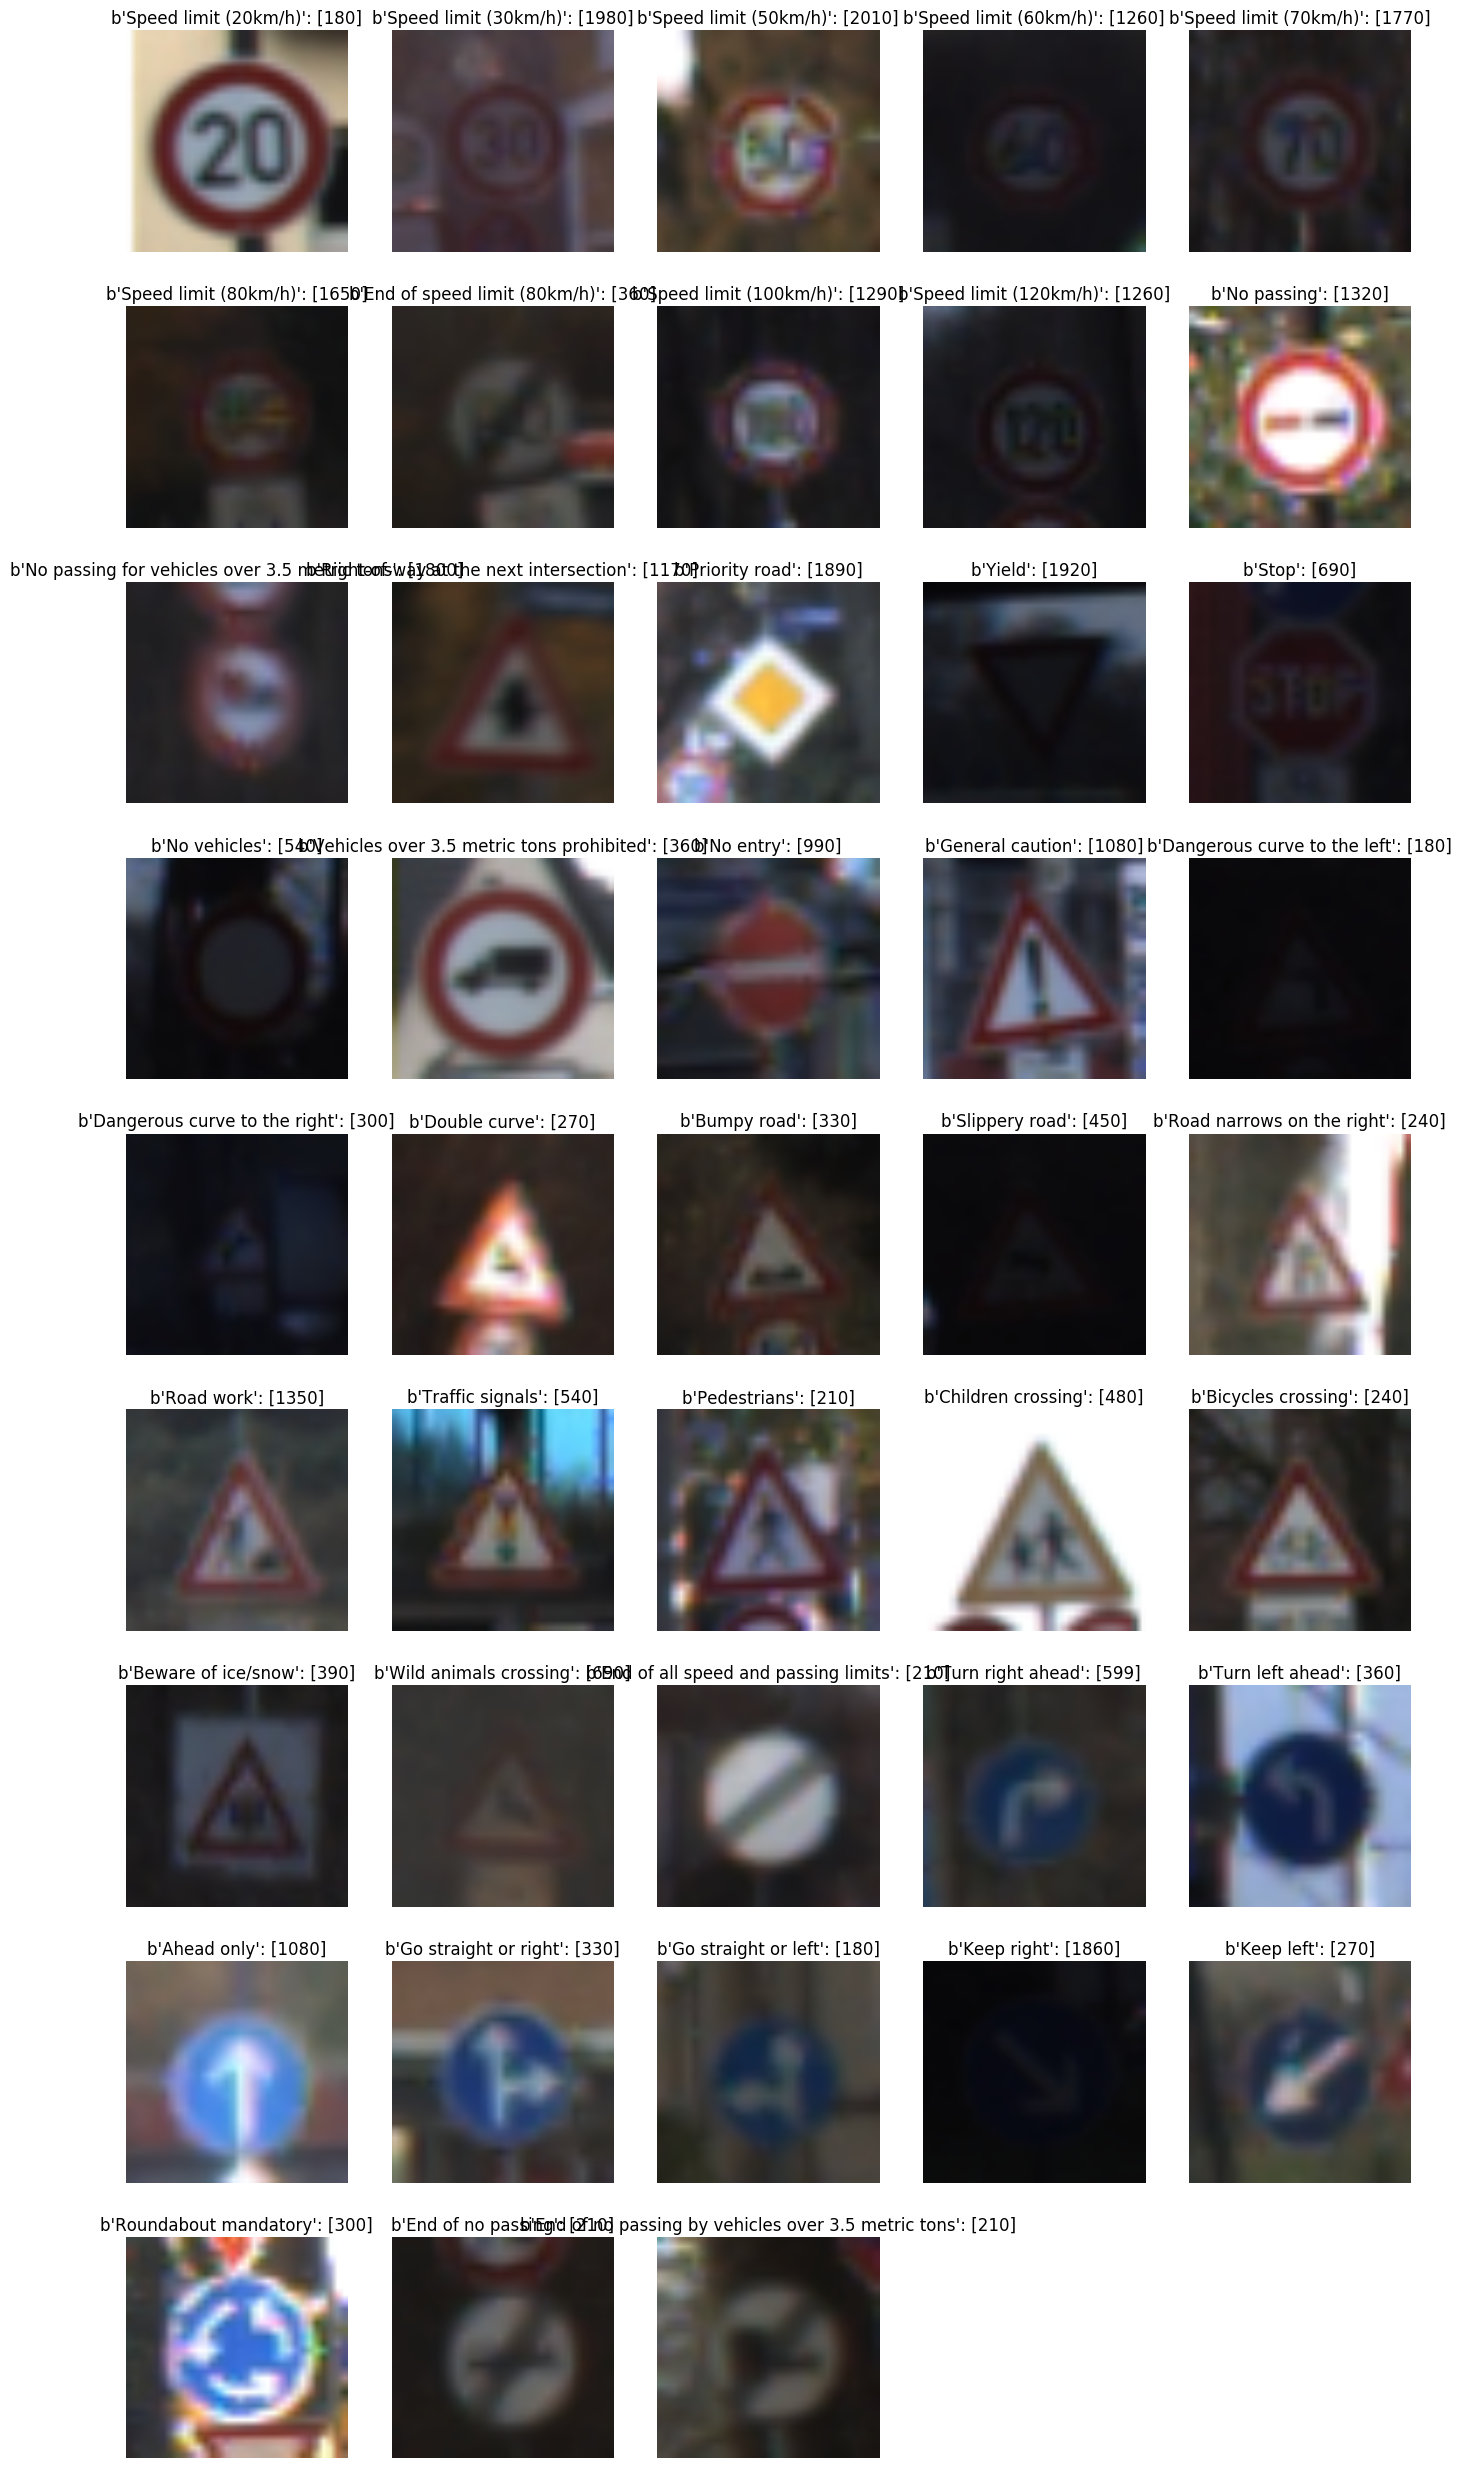

In [4]:
import random
import numpy as np

## Display images from each of the class types
import cv2
from scipy.misc import toimage

plt.subplots(figsize=(20, 35))
nrows = 10
ncols = 6

plt_row = 1
plt_col = 1
for i in range(n_classes):
    
    class_idx = np.where(y_train==i)[0][0]
    class_size = int(len(y_train[np.where(y_train==i)]))
    plt.subplot2grid((nrows, ncols), (plt_row, plt_col))
    plt.imshow(toimage(X_train[class_idx]))
    plt.axis("off")
    label = "%s: [%d]" % (signnames['SignName'][i], class_size)
    plt.title(label)
    
    plt_col += 1
    if (plt_col >= ncols):
        plt_row += 1
        plt_col = 1


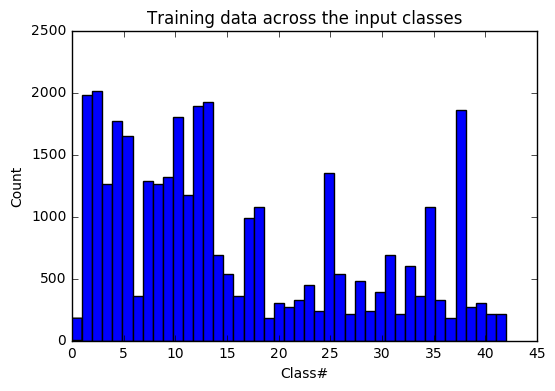

In [5]:
## Display the distribution of images classes
def show_class_distribution():
    plt.hist(y_train, n_classes)
    plt.title("Training data across the input classes")
    plt.xlabel("Class#")
    plt.ylabel("Count")
    plt.annotate
    plt.show()

show_class_distribution()

### Pre-process the Data Set (normalization, grayscale, etc.)

As we can see from garph above, the data provided is quite imbalanced. We will normalize (mean center) and augment the data by rotating the images slightly (left and right) for each of the imbalanced sets. 

Before augmenting training set:   34799 samples

After augmenting training set:    86341 samples

Flipping the images did not yield good results due to the positional features of some of the traffic signs like those with numbers (eg 120 becomes 021 on horizontal flip) and hence was removed.


Using TensorFlow backend.


Finished rotating images
Before training size:   34799 samples
After training size:   86341 samples


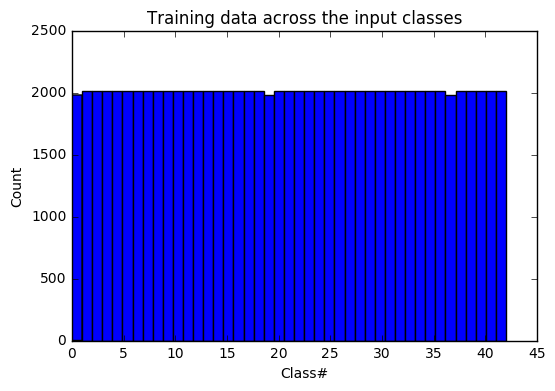

Finished one hot encoding labels
Finished normalize and augmenting data


In [6]:
#Preprocess and Augemnt the Data
from keras.utils import np_utils



def normalize(x):
    """
    Normalize a list of  image data in the range of 0 to 1 and mean center it
    : x: List of image data.  The image shape is different for each image
    : return: Numpy array of normalize data
    """
    # = a + (( x - xmin) * ( b - a))/(xmax - xmin)
    # xmax = 255, xmin = 0, a = 0, b = 1
    return (x/255.0 - 0.5)

def rotate(image, angle):
    # grab the dimensions of the image
    (h, w) = image.shape[:2]

    # calc center of image
    center = (w // 2, h // 2)
    
    scale = 1.0

    # perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    # return the rotated image
    return rotated
   
X_augment, y_augment = [], []
for image, label in zip(X_train, y_train):
    image = normalize(image)
    X_augment.append(image)
    y_augment.append(label)
#    X_augment.append(cv2.flip(image, 1))
#    y_augment.append(label)
    
#print ("Finished flipping images")

#X_augment = normalize(X_train)
#y_augment = y_train

## Add rotated images for imbalanced classes
samples_per_class = np.bincount(y_train)
angles = [-2, 2, -5, 5, -7, 7, -11, 11, -15, 15]

## Images should be 32x32
image_cols = X_train.shape[1]
image_rows = X_train.shape[2]
max_samples_count = max(samples_per_class)
for class_idx in range(n_classes):
    this_class_count = samples_per_class[class_idx]
    shortby = max_samples_count - this_class_count
    #print(" shortby : ", str(shortby))
    
    this_class_image_ids = np.where(y_train == class_idx)[0]
    for image_idx in this_class_image_ids:
        for angle in angles:
            image = X_train[image_idx]
            label = y_train[image_idx]
            rotated = rotate(image, angle)
            X_augment.append(normalize(rotated))
            y_augment.append(label)
            
            shortby -= 1
            if (shortby <= 0):
                break
            #plt.show(image)
            #plt.show(rotated)
        if (shortby <= 0):
            break

print ("Finished rotating images")

print("Before training size:   {} samples".format(len(X_train)))


#X_train = np.append(X_train, X_augment, axis=0)
#y_train = np.append(y_train, y_augment, axis=0)

X_train = np.array(X_augment)
y_train = np.array(y_augment)

X_test = normalize(X_test)
X_valid = normalize(X_valid)

print("After training size:   {} samples".format(len(X_train)))

show_class_distribution()

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_valid = np_utils.to_categorical(y_valid)
print ("Finished one hot encoding labels")


print ("Finished normalize and augmenting data")



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

Ran multiple experiements to arrive at the current model. Started off with Lenet and then simplified the model based on training. The classifier has two stages:

1. First stage is the Convolutional part with three conv layers with Relu. Maxpooling and dropout laters were removed after running experiments (see details below). 

2. Second stage is the Classifier part. Here the output from the first stage is flattened and then passed onto a Dense layer with 128 neurons and dropout. The final output layers gives the predictions for the 43 classes provided as part of the training data.

I was getting poor results with Maxpooling layers, so afrter watching the [Google Next Talk: Tensorflow without PhD](https://www.youtube.com/watch?v=u4alGiomYP4). As suggested in the talk, removed the Maxpooling and Dropout from the convolutional layers, added another conv layer and increased the filter size. For the dense layer reduced the neurons to 128 and made the dropout to be large (0.75). With these changes was able to get to a validation accuracy of 0.9565. The network also trained faster and I was able to reduce the epoch to 25. 

Also tuned the pre-processing of data during this process as explained in previous sections. Added the rotations and removed fliping of images. 

Different learning rates were tried, 0.01 gave the best results with a decay or learnrate/#epochs for SGD. Also added ReduceLROnPlateau by monitoring the validation loss.  

My final model results were:

training set accuracy of 0.9572
validation set accuracy of 0.9565
test set accuracy of 0.9



### Trained on AWS
For the training itself, I tested on AWS g2xlarge, P2.xlarge both of which were giving memory warnings in the jupyter console. On swithcing to the p2.8xlarge the memory warnings went away, however the speed of training execution did not increase significatly despite having 8 GPUs vs 1 for the other instance types. Learnt later that Tensorflow does not automaticallu parallelize the model on multiple GPUs. For distributed training one has to either parallelize the data and/or the model. New features in Tensorflow 1.2 have added higher level Experiment support for data parallelization, but still require setup of the cluster. For future exploration....


In [7]:
### Shuffle the data

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
# Create the model

# Import Keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
##K.set_image_dim_ordering('th')
# Need to set dim ordering to 'th' even for Tensorflow backend 
#with dim_ordering "th" data is expected as (data_x, data_y, num_channels)
#with dim_ordering "tf" data shape is expected as (num_channels, data_x, data_y)

model = Sequential()
model.add(Conv2D(3, input_shape=(32, 32, 3),  kernel_size=(6,6), padding='same', data_format='channels_last', activation='relu', use_bias=True, name='conv1'))
#model.add(Dropout(0.2, name='drop1'))
model.add(Conv2D(6, kernel_size=(5, 5), padding='same', data_format='channels_last', activation='relu', use_bias=True, name='conv2'))
#model.add(MaxPooling2D(pool_size=(1, 1), name='pool1'))
#model.add(Dropout(0.2, name='drop2'))
model.add(Conv2D(6, kernel_size=(4, 4), padding='same', data_format='channels_last', activation='relu', use_bias=True, name='conv3'))

model.add(Flatten(name='flat1'))
#model.add(Dense(512, input_dim=32768, activation='relu', kernel_constraint=maxnorm(3), name='dense1'))
model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3), use_bias=True, name='dense1'))
model.add(Dropout(0.75, name='drop1'))
model.add(Dense(n_classes, activation='softmax', name='output'))

# Compile model
epochs = 25
learn_rate = 0.01
decay = learn_rate/epochs
sgd = SGD(lr=learn_rate, decay=decay, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 3)         327       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 6)         456       
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 6)         582       
_________________________________________________________________
flat1 (Flatten)              (None, 6144)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               786560    
_________________________________________________________________
drop1 (Dropout)              (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 43)                5547      
Total para

### Train, Validate and Test the Model

Experimented with different nolrmalizers for reducing the overfitting errors. Adam optimizer used in leNet was not giving good results. Swithced to SGD aith maxnorm set on the conv layers based on the C231n Lecture notes. 

Final validation accurary improved to 0.9510 after making the changes suggested in Google talk (remove maxpool and dropout from conv layers, large dropout after dense layer). 

Experiments were done with Early Stopping, Reducing LR combinations.

The numbers may not be shown in the saved notebook (or experted html). Had to switch to used Keras-tqdm for the performance display to get around the websocket connection broken error during training. 
Note: tqdm stopped worked after upgrading to Keras 2, switched to ProgBarLogger

In [9]:
### Train the model

#Wesocket ping error if using default verbose settings
#Use keras-tqdm as workaround
#Used fix from Rohit Rawat for Keras-tqdm for fit_generator https://github.com/bstriner/keras-tqdm/issues
#Other options to set verbose=0 or redirect sys.out to file
#from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ReduceLROnPlateau, TensorBoard, ProgbarLogger, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

tbCallBack = TensorBoard(log_dir='../logs', histogram_freq=5, write_graph=True, write_images=True)

esCallback = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')


# Fit the model
#history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), nb_epoch=epochs, shuffle=True, batch_size=96, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), reduce_lr, tbCallBack])
#history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, nb_epoch=epochs, shuffle=True, batch_size=96, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), reduce_lr])
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, shuffle=True, batch_size=96, verbose=2, callbacks=[ProgbarLogger(), reduce_lr, esCallback])
#history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, shuffle=True, batch_size=96, verbose=2, callbacks=[ProgbarLogger(), reduce_lr])
#history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, shuffle=True, batch_size=96, verbose=2, callbacks=[ProgbarLogger(), esCallback])
#history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, shuffle=True, batch_size=96, verbose=2, callbacks=[ProgbarLogger()])

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 86341 samples, validate on 4410 samples
Epoch 1/25
Epoch 1/25
13s - loss: 1.7843 - acc: 0.4931 - val_loss: 0.4950 - val_acc: 0.8610
13s - loss: 1.7843 - acc: 0.4931 - val_loss: 0.4950 - val_acc: 0.8610
Epoch 2/25
Epoch 2/25
12s - loss: 0.6717 - acc: 0.7853 - val_loss: 0.3423 - val_acc: 0.9025
12s - loss: 0.6717 - acc: 0.7853 - val_loss: 0.3423 - val_acc: 0.9025
Epoch 3/25
Epoch 3/25
12s - loss: 0.4706 - acc: 0.8496 - val_loss: 0.2479 - val_acc: 0.9270
12s - loss: 0.4706 - acc: 0.8496 - val_loss: 0.2479 - val_acc: 0.9270
Epoch 4/25
Epoch 4/25
12s - loss: 0.3668 - acc: 0.8797 - val_loss: 0.2357 - val_acc: 0.9331
12s - loss: 0.3668 - acc: 0.8797 - val_loss: 0.2357 - val_acc: 0.9331
Epoch 5/25
Epoch 5/25
12s - loss: 0.3112 - acc: 0.8978 - val_loss: 0.2128 - val_acc: 0.9383
12s - loss: 0.3112 - acc: 0.8978 - val_loss: 0.2128 - val_acc: 0.9383
Epoch 6/25
Epoch 6/25
12s - loss: 0.2715 - acc: 0.9095 - val_loss: 0.2081 - val_acc: 0.9424
12s - loss: 0.2715 - acc: 0.9095 - val_loss: 0.20

In [10]:
print(history.history['val_acc'])
print(scores)

[0.86099776378294235, 0.90249436080050305, 0.92698415412383828, 0.93310660115715593, 0.93832202492928019, 0.94240365385198266, 0.9473923164160073, 0.95102043654642954, 0.9469388071371585, 0.94648529574984597, 0.95351477074785296, 0.95464855197335585, 0.953741521900203, 0.95396827986451238, 0.95374152595494066, 0.95714288341755771, 0.95419503766663216, 0.95306125514361328]
[0.32836209466903576, 0.93372921621808913]


In [11]:
# See how the learning rate was reduced over the epochs

print(history.history['lr'])

[0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0099999998, 0.0019999999, 0.0019999999]


dict_keys(['loss', 'val_loss', 'lr', 'val_acc', 'acc'])


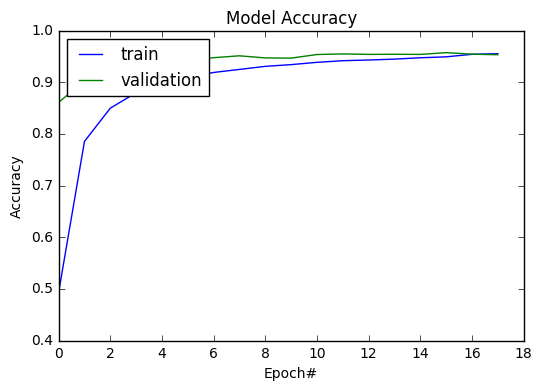

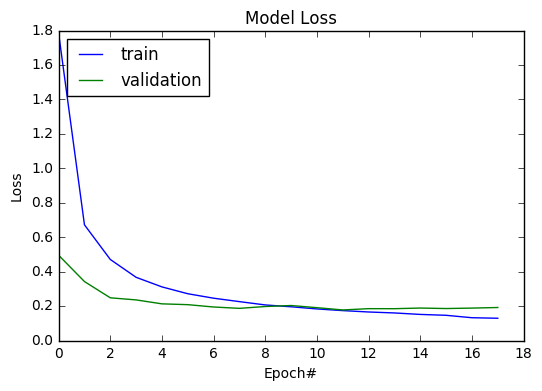

In [12]:
# list all data in history
print(history.history.keys())


# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch#')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch#')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
##Load Saved model from disk
from keras.models import model_from_json


# load json and create model
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


# load weights into new model
loaded_model.load_weights("model2.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
# Compile model
learn_rate = 0.01
decay = learn_rate/epochs
sgd = SGD(lr=learn_rate, decay=decay, momentum=0.9)
loaded_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


Loaded model from disk


# Visualize the Loaded Model

Make sure graphviz is installed and present in the path (/usr/bin/dot)
Follow steps from http://stackoverflow.com/questions/36886711/keras-runtimeerror-failed-to-import-pydot-after-installing-graphviz-and-pyd

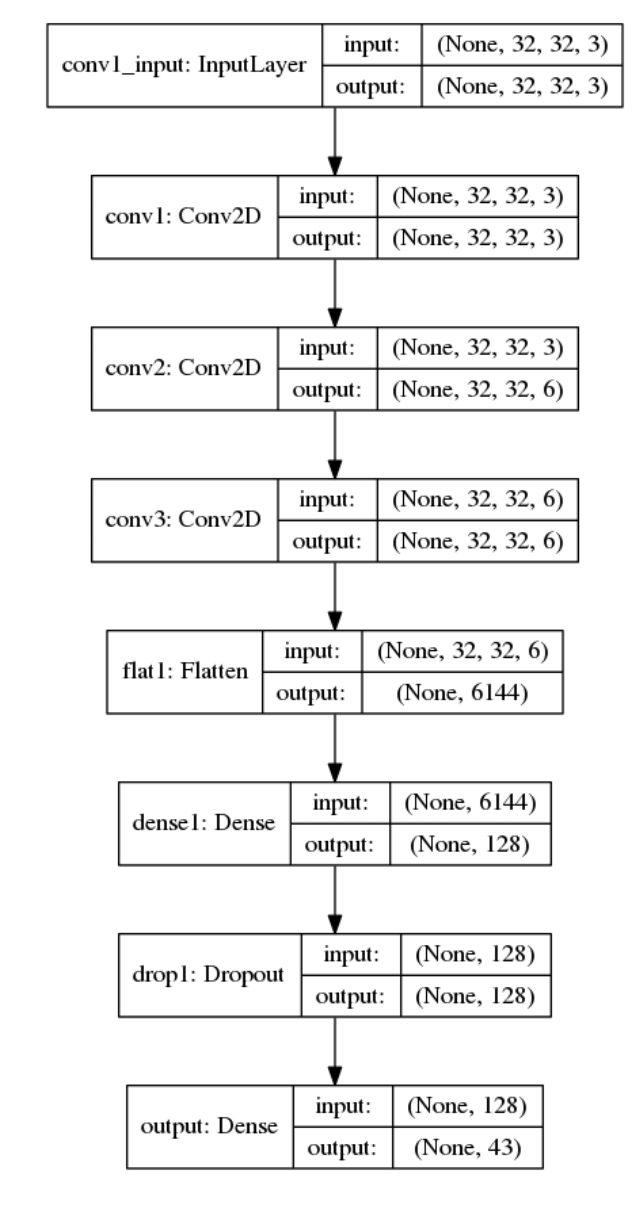

In [15]:
## Visualize the Loaded Model

import pydot_ng as pydot
from keras.utils import plot_model

plot_model(loaded_model, to_file='model.png', show_shapes=True)

img = cv2.imread('model.png')

# original image
plt.subplots(figsize=(10,15))
plt.subplot(111)
plt.axis('off')
plt.imshow(img)

In [16]:
# show couple of random images from the test data predictions

import random


def show_example_predictions(preds, features, labels, show_errors=False):

    # reverse one hot encoding
    predicted_labels = np.argmax(np.round(preds), axis=1)
    known_labels = np.argmax(labels, axis=1)

    # compare model predictions with known labels
    result = (predicted_labels == known_labels)

    indices = [i for i, x in enumerate(result) if x == (not show_errors)]

    # show an image from each class in a grid
    plt.subplots(figsize=(20, 35))
    for i in range(5):
        image_id = random.choice(indices)
        plt.subplot(150 + 1 + i)
        plt.imshow(toimage(features[image_id]))

        label_id = predicted_labels[image_id]
        predicted_title = signnames['SignName'][label_id]

        label_id = known_labels[image_id]
        known_title = signnames['SignName'][label_id]

        plt.title("Predicted: {}".format(predicted_title))
        plt.xlabel("Actual: {}".format(known_title))

In [17]:
# run predictions on test set
predictions = loaded_model.predict(X_test)

print("Ran predictions on test set")

Ran predictions on test set


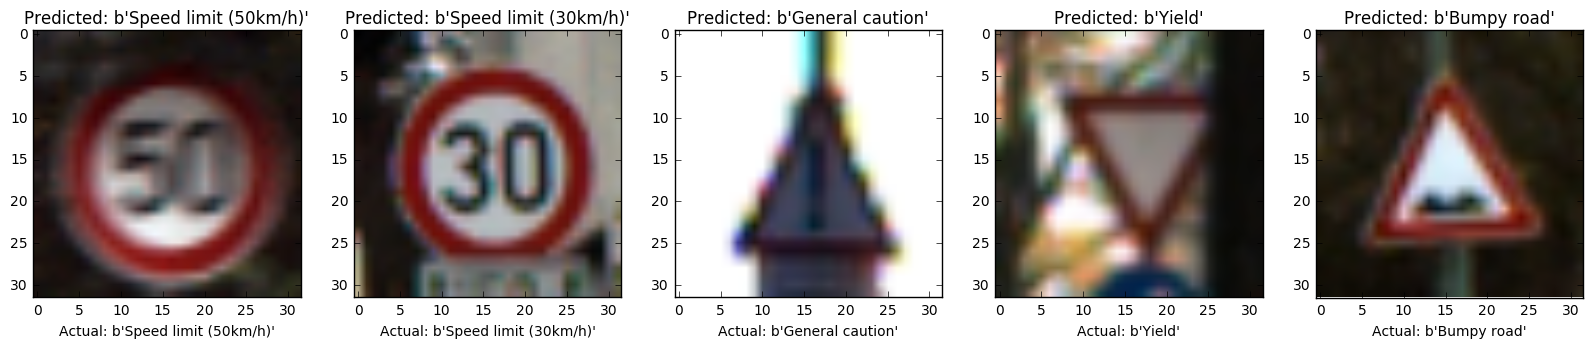

In [18]:
#Show Correct Predictions
show_example_predictions(predictions, X_test, y_test, False)

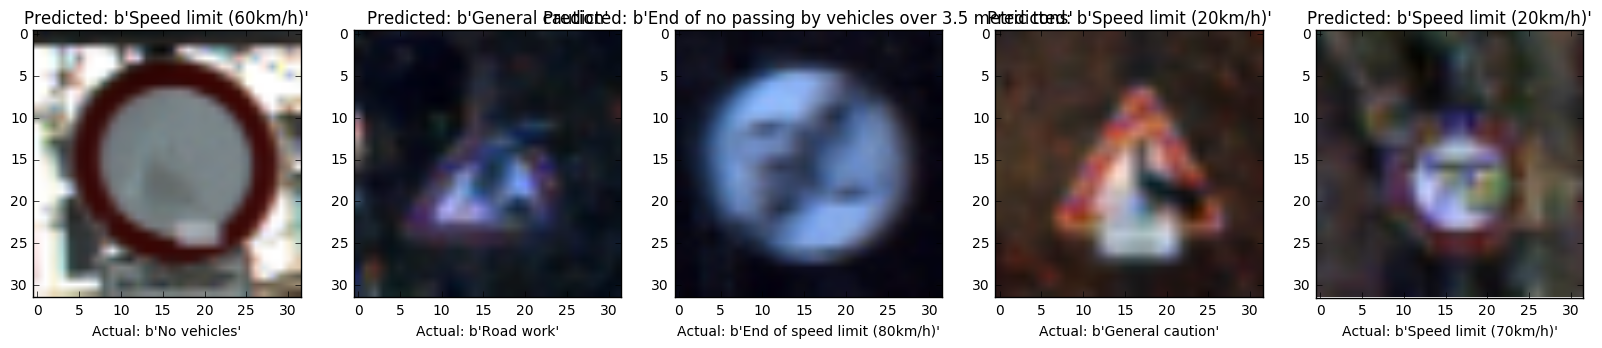

In [19]:
#Show Incorrect Predictions
show_example_predictions(predictions, X_test, y_test, True)

---

## Step 3: Test a Model on New Images

To get more insights on how the model is working, downloaded six pictures of German traffic signs from the web and used the model to predict the traffic sign type.


### Load and Output the Images

It was very difficult to find 'clean' German traffic sign images on the net. Most files were from stock / getty had a watermark in them so could not be used. Further the quality of the training set images is very poor, so the chances of accurate predictions will be much lower than the model testing accuracy numbers.

In [20]:

# show couple of random images from the given set
def show_output_predictions(preds, features, labels):

    # reverse one hot encoding
    predicted_labels = np.argmax(np.round(preds), axis=1)
    
    indices = [i for i, x in enumerate(predicted_labels) ]
    print (indices)
    if len(indices) ==0: 
        return

    # show an image from each class in a grid
    plt.subplots(figsize=(20, 35))
    for i in range(len(labels)):
        image_id = indices[i]
        
        plt.subplot(8, 8, i + 1)
        plt.imshow(toimage(features[image_id]))

        label_id = predicted_labels[image_id]
        predicted_title = signnames['SignName'][label_id]

        plt.title("Predicted: {}".format(predicted_title))
        


In [21]:
# Load the images and plot them here.
### Feel free to use as many code cells as needed.

from os import listdir
import cv2

plt.close('all')

path = '../images/'
X_new = []

images = listdir(path)
#images = listdir(path + '*.jpg')
for inp in enumerate(images):
    try:
        img = cv2.imread(path + inp[1])
        #img = cv2.resize(img, (32, 32))
        X_new.append(normalize(img))
    except Exception as x:
        continue
        
X_new = np.asarray(X_new)

### Predict the Sign Type for Each Image

[0, 1, 2, 3, 4, 5]


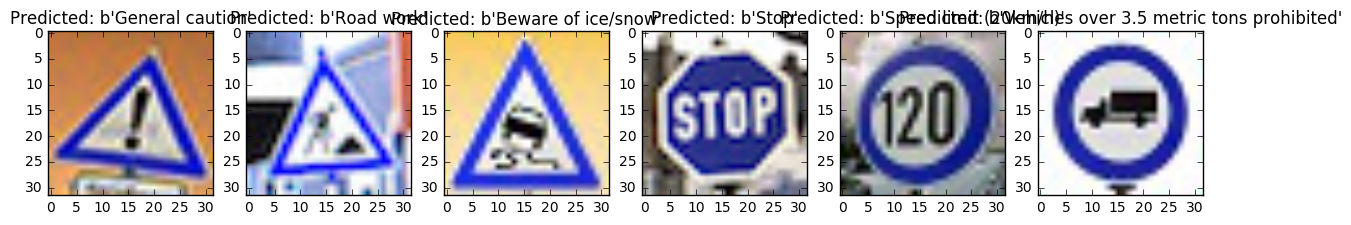

In [22]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

predicts = loaded_model.predict(X_new)
y_new = np.argmax(np.round(predicts), axis=1)

show_output_predictions(predicts, X_new, y_new)

### Analyze Performance

The performance of the model varied after each training, suggesting that more robust model is needed. In this run four out of six images gave correct results. Better images are needed for training to build a more robust solution. 

| Image			        |     Prediction	        					| 
|:---------------------:|:---------------------------------------------:| 
| General Caution      	| General Caution   							| 
| Road Work     		| Road Work										|
| Slippery Road			| Bware of ice/snow								|
| Stop Sign	      		| Stop Sign 					 				|
| 120 km Speed Limit	| 20 km Speed Limit    							|
| 3.5 ton prohibited	| 3.5 ton prohibited   							|




In [27]:
### Calculate the accuracy for these 5 new images. 

#Only four images from the web are showing proper labels so far, overall accuracy is not that good due to the high noise factor in the training data

correct_labels = 4
test_accuracy = (correct_labels/(len(X_new))*100)
print ("Test run accuracy: {}".format(test_accuracy))

Test run accuracy: 66.66666666666666


### Output Top N Softmax Probabilities For Each Image Found on the Web

For each of the new images, vizalize the model's top 3 softmax probabilities to show the **certainty** of the model's predictions


TopKV2(values=array([[ 1.000,  0.000,  0.000],
       [ 1.000,  0.000,  0.000],
       [ 0.997,  0.002,  0.000],
       [ 1.000,  0.000,  0.000],
       [ 1.000,  0.000,  0.000],
       [ 1.000,  0.000,  0.000]], dtype=float32), indices=array([[18, 26, 24],
       [25, 24, 27],
       [30, 11, 40],
       [14, 33, 17],
       [ 0,  4, 40],
       [16,  9, 12]], dtype=int32))
[0, 1, 2, 3, 4, 5]


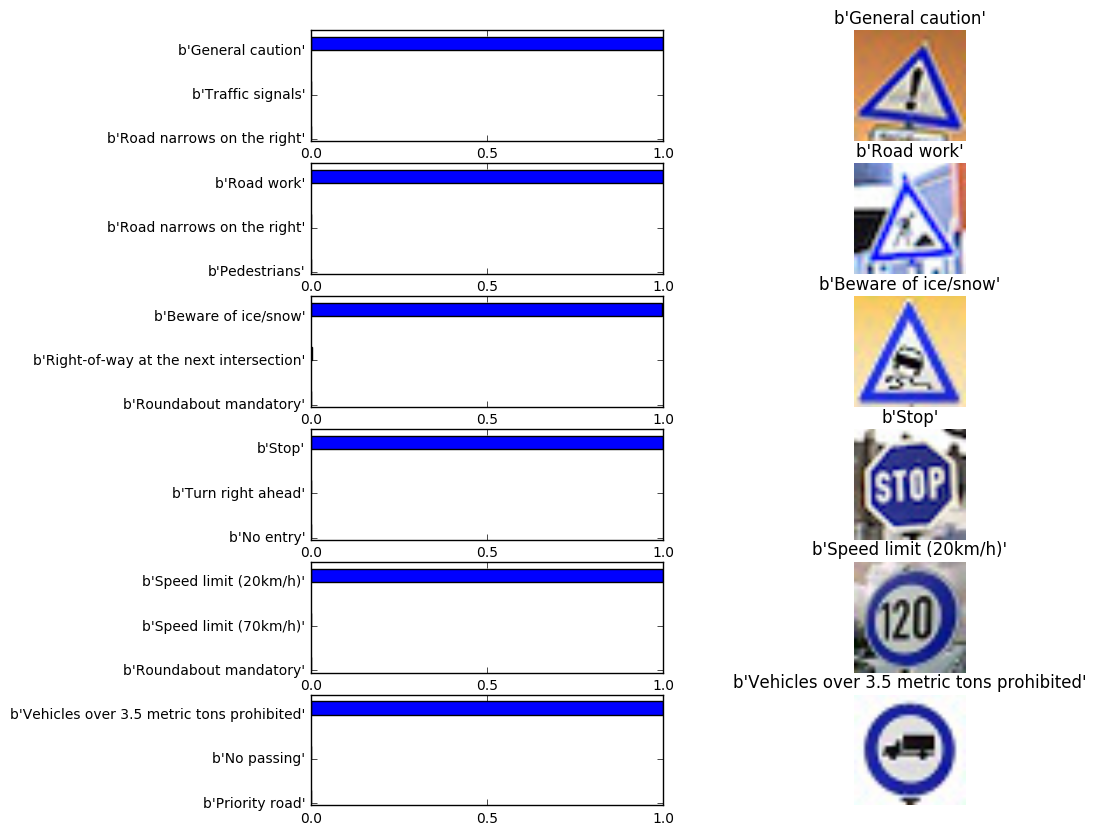

In [24]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
import tensorflow as tf

# show couple of random images from the given set
def show_topn_predictions(predictions, features, labels, k=5):
    label_names = signnames['SignName']
    label_ids = signnames['ClassId']

    # reverse one hot encoding
    predicted_labels = np.argmax(np.round(predictions), axis=1)
    
    with tf.Session() as sess:
        topN = sess.run(tf.nn.top_k(tf.constant(predictions), k=k))
        print(topN)
        #print(predictions)
    
    #return
    
    indices = [i for i, x in enumerate(predicted_labels) ]
    print (indices)
    if len(indices) ==0: 
        return
    
    plt.close('all')
    
    fig, axies = plt.subplots(nrows=len(labels), ncols=2, figsize=(10,10))
    
    n_predictions = k
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, topN.indices, topN.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        top_pred = pred_names[0]

        axies[image_i][1].imshow(toimage(feature))
        axies[image_i][1].set_title(top_pred)
        axies[image_i][1].set_axis_off()

        axies[image_i][0].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][0].set_yticks(ind + margin)
        axies[image_i][0].set_yticklabels(pred_names[::-1])
        axies[image_i][0].set_xticks([0, 0.5, 1.0])
  
   
    
show_topn_predictions(predicts, X_new, y_new, 3)

---

## Step 4: Visualize the Neural Network's State with Test Images

Visualize the Feature maps for each of the convolution layers. As we cam see from the images of the feature map, different attributes of the image are captures by each of the "filters". Feature maps for "3.5 metric tone prohibited" image were analyzed as it was generally identified correctly by the model. The first layer is detecting the edges of the outer circle shape, with some activation of the truck symbol. The next two layers are detecting the finner grained features of the symbol.  

The feature map analysis is still more of an art than science, and required deeper analysis with larger datasets to get greater intuition. State of the art further needs to evlolve here with better tooling (eg features in Tensorboard itself that shed more light on the feature map activations). A time lapse analysis over all images from the training set would help, but I did not have time to imvestigate that. Left for future work....


In [36]:
### Visualize your network's feature maps here.

from keras.models import Model


test_img = "../images/4.jpg"

def visualize_model_layer_output(layer_name, activation_min=-1, activation_max=-1 ,plt_num=1):
    vixModel = Model(input=loaded_model.input, output=loaded_model.get_layer(layer_name).output)
    
    print("Feature Maps for layer: " + layer_name)

    img = cv2.imread(test_img)
    #convert to array of single image
    img = np.expand_dims(normalize(img), axis=0)
    #img = np.expand_dims(img, axis=0)

    activation = vixModel.predict(img)
    print("activation features shape: ", activation.shape)
    
    # plot features
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(20,20))
    for featuremap in range(featuremaps):
        if featuremap >= 48:
            break
        #print (featuremap)
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("co...)`


Feature Maps for layer: conv1
activation features shape:  (1, 32, 32, 3)
Feature Maps for layer: conv2
activation features shape:  (1, 32, 32, 6)
Feature Maps for layer: conv3
activation features shape:  (1, 32, 32, 6)


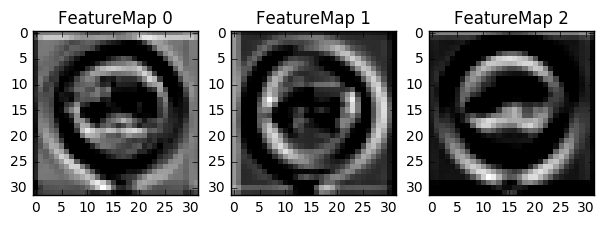

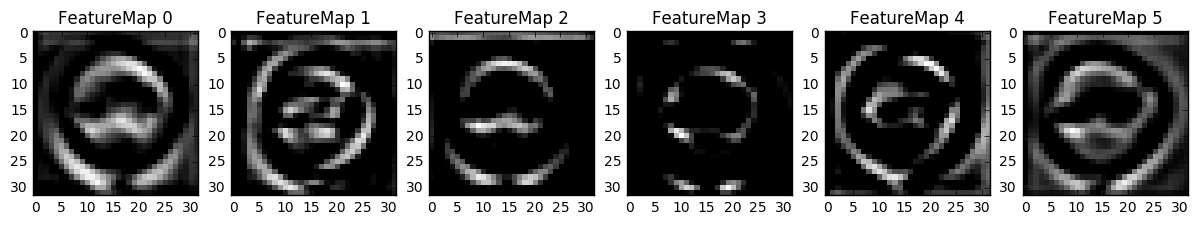

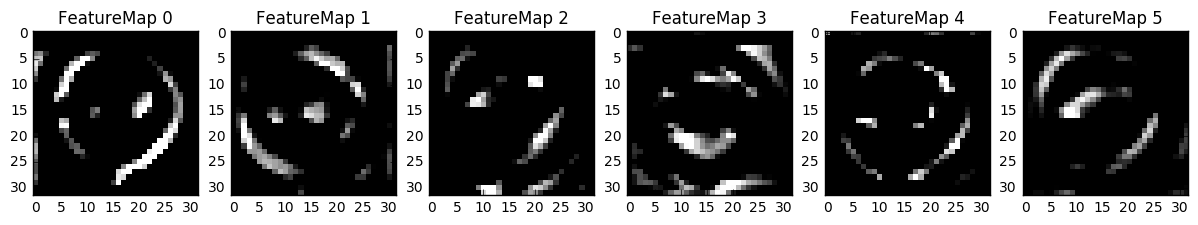

In [37]:
visualize_model_layer_output("conv1", plt_num=1)
visualize_model_layer_output("conv2", plt_num=2)
visualize_model_layer_output("conv3", 2, 10, plt_num=3)
